In [151]:
import pandas as pd
from statsmodels.multivariate.manova import MANOVA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from xgboost import plot_importance
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from statsmodels.multivariate.manova import MANOVA
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.impute import SimpleImputer

random.seed(42)
np.random.seed(42)

In [152]:

data = pd.read_excel('BD_numericas.xlsx')


In [153]:
df = data

In [154]:
df.head()

,id,NIVEL ESTUDIOS,ESTADOCIVIL,GÉNERO,TIPO VIVIENDA,TIEMPO EN RESIDENCIA,ESTRATO,TIPO CONTRATO,TIEMPO ACTIVIDAD,INGRESOS FIJOS,...,CUOTAMENSUAL,CODIGO CIIU,SCORE,SALDO CAPITAL,SALDO VENCIDO,DIAS DE MORA,FRANJA DE MORA,EDAD,DIAS EN APROBAR,TARGET
0,0,5,0,0.0,2,3.0,5,0,5.0,13000000,...,632001.190699,8560,649,0,0.0,0,0,42,0,1
1,1,3,0,1.0,1,21.0,4,1,21.0,19000000,...,232260.179192,4610,843,5141500,0.0,0,0,60,0,1
2,2,3,3,1.0,2,15.0,3,0,1.0,1500000,...,91504.941888,4799,630,1259000,0.0,0,0,20,0,1
3,3,3,3,1.0,1,7.0,4,0,4.0,4000000,...,115102.274644,9609,754,2492576,0.0,0,0,29,0,1
4,4,5,0,1.0,1,19.0,4,2,1.0,16000000,...,84800.457032,4799,503,1840083,0.0,0,0,18,0,1


In [155]:
df['MORA'] = (df['DIAS DE MORA'] >= 30).astype(int)


In [156]:
df.columns = df.columns.str.replace(" ", "_")

In [157]:
variables_manova = [
    'SCORE',
    'MONTO_DESEMBOLSO',
    'EDAD',
    'NIVEL_ESTUDIOS',
    'INGRESOS_FIJOS',
    'GASTOS_DE_SOSTENIMIENTO',
    'ACTIVOS',
    'TIEMPO_ACTIVIDAD',
    'TIEMPO_EN_RESIDENCIA',
    'CODIGO_CIIU',
    'ESTADOCIVIL',
    'ESTRATO'
]




In [158]:
df['TOTAL_INGRESOS']

,TOTAL_INGRESOS
0,15500000.0
1,19000000.0
2,1500000.0
3,7500000.0
4,16000000.0
...,...
45811,15000000.0
45812,2500000.0
45813,6000000.0
45814,2400000.0


In [159]:
scaler = StandardScaler()
df_scaled = df.copy()

df_scaled[variables_manova] = scaler.fit_transform(df[variables_manova])

maov_scaled = MANOVA.from_formula(
    "SCORE + INGRESOS_FIJOS + TOTAL_INGRESOS + TIEMPO_ACTIVIDAD + TIEMPO_EN_RESIDENCIA + EDAD + NIVEL_ESTUDIOS + ACTIVOS + GASTOS_DE_SOSTENIMIENTO + CODIGO_CIIU + ESTADOCIVIL + ESTRATO ~ MORA",
    data=df_scaled
)

print(maov_scaled.mv_test())

                        Multivariate linear model
                                                                         
-------------------------------------------------------------------------
       Intercept          Value   Num DF   Den DF      F Value     Pr > F
-------------------------------------------------------------------------
          Wilks' lambda    0.0001 1.0000 16266.0000 118963166.1735 0.0000
         Pillai's trace    0.9999 1.0000 16266.0000 118963166.1735 0.0000
 Hotelling-Lawley trace 7313.6091 1.0000 16266.0000 118963166.1735 0.0000
    Roy's greatest root 7313.6091 1.0000 16266.0000 118963166.1735 0.0000
-------------------------------------------------------------------------
                                                                         
--------------------------------------------------------------------------
               MORA           Value   Num DF    Den DF    F Value   Pr > F
------------------------------------------------------------

LDA

In [160]:

# Imputación de NA
imp = SimpleImputer(strategy="median")
X = imp.fit_transform(df[variables_manova])
y = df["MORA"]

# Balanceo con SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

#Entrenamiento del modelo
lda = LinearDiscriminantAnalysis()
lda.fit(X_bal, y_bal)

y_pred = lda.predict(X)

print("\n Accuracy LDA:", accuracy_score(y, y_pred))
print("\n Classification Report:\n", classification_report(y, y_pred))
print("\n Matriz de Confusión:\n", confusion_matrix(y, y_pred))



 Accuracy LDA: 0.6615592806006635

 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.68      0.77     38584
           1       0.24      0.54      0.33      7232

    accuracy                           0.66     45816
   macro avg       0.56      0.61      0.55     45816
weighted avg       0.79      0.66      0.70     45816


 Matriz de Confusión:
 [[26426 12158]
 [ 3348  3884]]


Importancia de las variables

In [161]:
coef = pd.DataFrame({
    "Variable": variables_manova,
    "Peso_LDA": lda.coef_[0]
}).sort_values(by="Peso_LDA", ascending=False)

print("\n Ranking de importancia LDA:\n")
print(coef)


 Ranking de importancia LDA:

                   Variable      Peso_LDA
8      TIEMPO_EN_RESIDENCIA  1.757982e-03
7          TIEMPO_ACTIVIDAD  8.398183e-04
9               CODIGO_CIIU  1.775232e-05
1          MONTO_DESEMBOLSO  9.824594e-08
4            INGRESOS_FIJOS  1.706622e-11
6                   ACTIVOS -2.075211e-15
5   GASTOS_DE_SOSTENIMIENTO -5.287602e-13
0                     SCORE -2.180585e-03
11                  ESTRATO -5.645346e-03
2                      EDAD -6.717172e-03
10              ESTADOCIVIL -2.904267e-02
3            NIVEL_ESTUDIOS -1.268808e-01


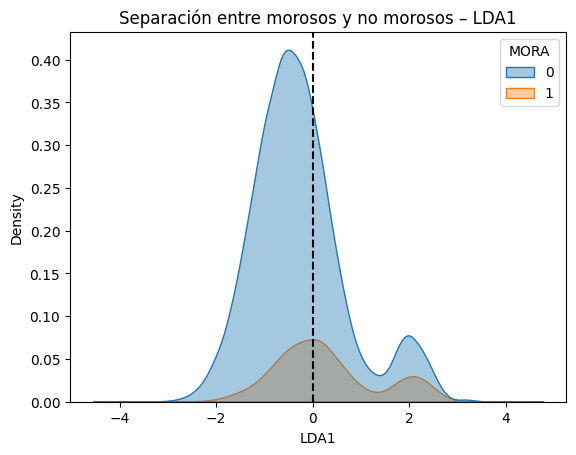

In [162]:
df_plot = pd.DataFrame({"LDA1": lda.transform(X)[:,0], "MORA": y})

sns.kdeplot(data=df_plot, x="LDA1", hue="MORA", fill=True, alpha=0.4)
plt.axvline(0, linestyle="--", color="black")
plt.title("Separación entre morosos y no morosos – LDA1")
plt.show()

Umbrales para LDA

In [163]:
y_proba_lda = lda.predict_proba(X)[:,1]

# Probando umbrales de 0.1 a 0.9
thresholds = [i/100 for i in range(5,95,5)]
resultados = []

for t in thresholds:
    y_pred_t = (y_proba_lda >= t).astype(int)
    resultados.append([
        t,
        precision_score(y, y_pred_t),
        recall_score(y, y_pred_t),
        f1_score(y, y_pred_t)
    ])

import pandas as pd
tabla_lda = pd.DataFrame(resultados, columns=["threshold","precision","recall","f1"])
print(tabla_lda)

    threshold  precision    recall        f1
0        0.05   0.157849  1.000000  0.272659
1        0.10   0.157852  1.000000  0.272664
2        0.15   0.157866  1.000000  0.272684
3        0.20   0.158175  0.999723  0.273134
4        0.25   0.160032  0.995575  0.275741
5        0.30   0.165023  0.976217  0.282321
6        0.35   0.176315  0.932799  0.296573
7        0.40   0.193232  0.844027  0.314469
8        0.45   0.215312  0.702295  0.329580
9        0.50   0.242114  0.537058  0.333763
10       0.55   0.263422  0.370437  0.307896
11       0.60   0.281334  0.261338  0.270968
12       0.65   0.289905  0.207688  0.242004
13       0.70   0.297641  0.181416  0.225430
14       0.75   0.319651  0.121681  0.176264
15       0.80   0.345309  0.023921  0.044743
16       0.85   0.305556  0.003042  0.006024
17       0.90   0.333333  0.000415  0.000829


In [164]:
# Probabilidades LDA ya entrenado
y_proba_lda = lda.predict_proba(X)[:,1]

# Cambiando treshold
threshold = 0.45
y_pred_045 = (y_proba_lda >= threshold).astype(int)

print(f"\n Resultados con Threshold = {threshold}")
print("Accuracy:", accuracy_score(y, y_pred_045))
print("\nClassification Report:\n", classification_report(y, y_pred_045))
print("\nConfusion Matrix:\n", confusion_matrix(y, y_pred_045))


 Resultados con Threshold = 0.45
Accuracy: 0.5490003492229789

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.52      0.66     38584
           1       0.22      0.70      0.33      7232

    accuracy                           0.55     45816
   macro avg       0.56      0.61      0.49     45816
weighted avg       0.79      0.55      0.61     45816


Confusion Matrix:
 [[20074 18510]
 [ 2153  5079]]


In [183]:
coef = pd.DataFrame({
    "Variable": variables_manova,
    "Peso_LDA": lda.coef_[0]
})

coef["|Peso|"] = coef["Peso_LDA"].abs()
coef.sort_values(by="|Peso|", ascending=False, inplace=True)

print("\n Ranking de variables LDA:\n")
print(coef.drop(columns="|Peso|"))


 Ranking de variables LDA:

                   Variable      Peso_LDA
3            NIVEL_ESTUDIOS -1.268808e-01
10              ESTADOCIVIL -2.904267e-02
2                      EDAD -6.717172e-03
11                  ESTRATO -5.645346e-03
0                     SCORE -2.180585e-03
8      TIEMPO_EN_RESIDENCIA  1.757982e-03
7          TIEMPO_ACTIVIDAD  8.398183e-04
9               CODIGO_CIIU  1.775232e-05
1          MONTO_DESEMBOLSO  9.824594e-08
4            INGRESOS_FIJOS  1.706622e-11
5   GASTOS_DE_SOSTENIMIENTO -5.287602e-13
6                   ACTIVOS -2.075211e-15


XGBOOST

In [166]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

imp = SimpleImputer(strategy="median")
X_train = imp.fit_transform(X_train)
X_test  = imp.transform(X_test)

model = XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91     11575
           1       0.45      0.02      0.04      2170

    accuracy                           0.84     13745
   macro avg       0.64      0.51      0.48     13745
weighted avg       0.78      0.84      0.78     13745

AUC: 0.6512327338236905


In [167]:
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
model.fit(X_train_bal, y_train_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [168]:
y_pred_bal = model.predict(X_test)
y_proba_bal = model.predict_proba(X_test)[:,1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("\n Resultados XGBoost + SMOTE")
print(classification_report(y_test, y_pred_bal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))
print("AUC:", roc_auc_score(y_test, y_proba_bal))


 Resultados XGBoost + SMOTE
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     11575
           1       0.39      0.03      0.05      2170

    accuracy                           0.84     13745
   macro avg       0.62      0.51      0.48     13745
weighted avg       0.77      0.84      0.78     13745

Confusion Matrix:
 [[11485    90]
 [ 2113    57]]
AUC: 0.6454135024036787


Seleccion del umbral

In [169]:
def evaluar_threshold_smote(thresholds, y_test, y_prob):
    resultados = []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        resultados.append([
            t,
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            f1_score(y_test, y_pred)
        ])
    return pd.DataFrame(resultados, columns=["threshold","precision","recall","f1"])


thresholds = np.arange(0.10, 0.91, 0.05)
tabla_t = evaluar_threshold_smote(thresholds, y_test, y_proba_bal)
print(tabla_t)

    threshold  precision    recall        f1
0        0.10   0.184502  0.898618  0.306146
1        0.15   0.207535  0.743779  0.324520
2        0.20   0.226311  0.547005  0.320162
3        0.25   0.250234  0.369585  0.298419
4        0.30   0.270542  0.223041  0.244506
5        0.35   0.318182  0.145161  0.199367
6        0.40   0.365455  0.092627  0.147794
7        0.45   0.350168  0.047926  0.084313
8        0.50   0.387755  0.026267  0.049202
9        0.55   0.421875  0.012442  0.024172
10       0.60   0.521739  0.005530  0.010944
11       0.65   0.285714  0.000922  0.001837
12       0.70   0.000000  0.000000  0.000000
13       0.75   0.000000  0.000000  0.000000
14       0.80   0.000000  0.000000  0.000000
15       0.85   0.000000  0.000000  0.000000
16       0.90   0.000000  0.000000  0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

In [170]:
threshold = 0.15
y_pred_thr = (y_proba_bal >= threshold).astype(int)

print(f"\n* Resultados con threshold = {threshold} *")
print("Accuracy:", accuracy_score(y_test, y_pred_thr))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_thr))
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_thr))


* Resultados con threshold = 0.15 *
Accuracy: 0.5111676973444889

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.47      0.62     11575
           1       0.21      0.74      0.32      2170

    accuracy                           0.51     13745
   macro avg       0.56      0.61      0.47     13745
weighted avg       0.80      0.51      0.57     13745


Matriz de Confusión:
[[5412 6163]
 [ 556 1614]]


In [171]:
auc = roc_auc_score(y_test, y_proba_bal)
print(f"\nAUC ROC del modelo: {auc:.4f}")


AUC ROC del modelo: 0.6454


Kmeans

In [172]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [173]:
vars_segmento = [
    "SCORE","CUOTAMENSUAL","INGRESOS_FIJOS",
    "TIEMPO_ACTIVIDAD","TIEMPO_EN_RESIDENCIA",
    "EDAD","TASA","PLAZO"
]

X_seg = df[vars_segmento]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_seg)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_pca)
    print(f"k={k} → Silhouette={silhouette_score(X_pca, labels):.3f}")


k=2 → Silhouette=0.409
k=3 → Silhouette=0.462
k=4 → Silhouette=0.447
k=5 → Silhouette=0.397
k=6 → Silhouette=0.399


In [174]:
# Elegimos el mayor sil
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df["cluster_final"] = kmeans.fit_predict(X_pca)

In [175]:
cluster_summary = df.groupby("cluster_final")[vars_segmento].mean()
print(cluster_summary)

                    SCORE  CUOTAMENSUAL  INGRESOS_FIJOS  TIEMPO_ACTIVIDAD  \
cluster_final                                                               
0              555.305393  2.377058e+13    4.439692e+06          4.518723   
1              717.579630  2.584281e+13    1.223826e+07         16.196041   
2              723.301411  3.736375e+13    5.902236e+06          9.812108   

               TIEMPO_EN_RESIDENCIA       EDAD      TASA      PLAZO  
cluster_final                                                        
0                          7.889780  31.543705  0.021176  34.466156  
1                         14.215986  54.754175  0.020860  32.939979  
2                         10.431412  41.709469  0.005893  15.732414  


Tamaño de clusters

In [176]:
df["cluster_final"].value_counts()

,count
cluster_final,
0,23121
1,13412
2,9283


In [177]:
df.groupby("cluster_final")[vars_segmento].median()

,SCORE,CUOTAMENSUAL,INGRESOS_FIJOS,TIEMPO_ACTIVIDAD,TIEMPO_EN_RESIDENCIA,EDAD,TASA,PLAZO
cluster_final,,,,,,,,
0,632.0,142539.035619,3000000.0,4.0,5.0,29.0,2.041800e-02,36.0
1,735.5,189949.940662,4000000.0,19.0,16.0,55.0,2.041800e-02,36.0
2,726.0,214825.333333,4000000.0,8.0,8.5,40.0,1.000000e-09,12.0


In [178]:
df[vars_segmento+["cluster_final"]].groupby("cluster_final").describe()

SCORE                                                    \
                 count        mean         std  min    25%    50%    75%   
cluster_final                                                              
0              23121.0  555.305393  255.068971 -8.0  549.0  632.0  710.0   
1              13412.0  717.579630  143.401963 -5.0  657.0  735.5  801.0   
2               9283.0  723.301411  109.855927 -5.0  654.0  726.0  793.0   

                     CUOTAMENSUAL                ...      TASA            \
                 max        count          mean  ...       75%       max   
cluster_final                                    ...                       
0              999.0      23121.0  2.377058e+13  ...  0.022497  0.030853   
1              999.0      13412.0  2.584281e+13  ...  0.022497  0.030853   
2              999.0       9283.0  3.736375e+13  ...  0.019291  0.029046   

                 PLAZO                                                    
                 count       mean       std  min   25%   50%   75%   max  
cluster_final                                                             
0              23121.0  34.466156  7.877808  3.0  36.0  36.0  36.0  60.0  
1              13412.0  32.939979  9.467874  3.0  30.0  36.0  36.0  60.0  
2               9283.0  15.732414  8.251549  3.0   9.0  12.0  24.0  36.0  

[3 rows x 64 columns]

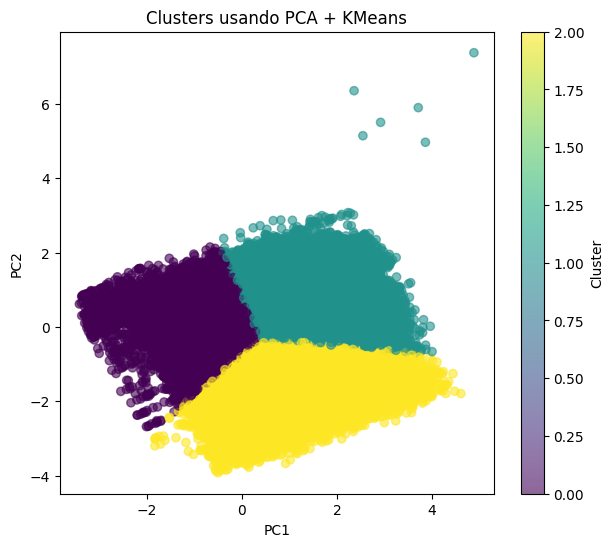

In [179]:
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster_final"], cmap="viridis", alpha=0.6)
plt.title("Clusters usando PCA + KMeans")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

In [180]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1','PC2'],
    index=vars_segmento
)
loadings

,PC1,PC2
SCORE,0.394226,-0.108339
CUOTAMENSUAL,0.003755,-0.005639
INGRESOS_FIJOS,0.022529,0.049937
TIEMPO_ACTIVIDAD,0.563232,0.259229
TIEMPO_EN_RESIDENCIA,0.315589,0.214788
EDAD,0.553678,0.253111
TASA,-0.245971,0.634295
PLAZO,-0.245309,0.637188


/tmp/ipython-input-1620874580.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.arrow(0,0, loadings.PC1[i]*3, loadings.PC2[i]*3, color='red', width=0.01)
/tmp/ipython-input-1620874580.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(loadings.PC1[i]*3.2, loadings.PC2[i]*3.2, var, color='red')


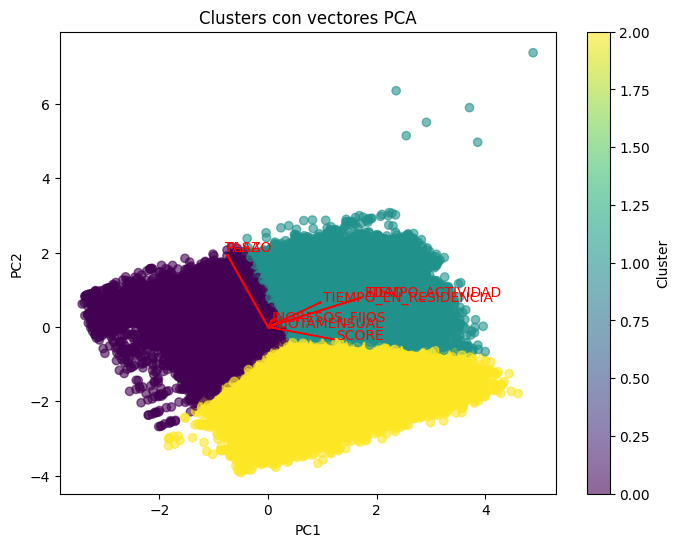

In [181]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster_final"], cmap="viridis", alpha=0.6)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters con vectores PCA")

for i, var in enumerate(loadings.index):
    plt.arrow(0,0, loadings.PC1[i]*3, loadings.PC2[i]*3, color='red', width=0.01)
    plt.text(loadings.PC1[i]*3.2, loadings.PC2[i]*3.2, var, color='red')

plt.show()

Robustez

In [182]:
from sklearn.metrics import classification_report

df_test = df.loc[y_test.index].copy()

subgroups = {
    "Género": "GÉNERO",
    "Estrato": "ESTRATO",
    "Nivel de estudios": "NIVEL_ESTUDIOS",
}

for nombre, col in subgroups.items():
    print(f"\n===== Robustez por {nombre} ({col}) =====")

    for valor in sorted(df_test[col].dropna().unique()):
        mask = df_test[col] == valor

        if mask.sum() < 100:
            continue

        print(f"\nSubgrupo: {valor}  (n = {mask.sum()})")
        print(classification_report(y_test[mask], y_pred_thr[mask], digits=2))


===== Robustez por Género (GÉNERO) =====

Subgrupo: 0.0  (n = 5226)
              precision    recall  f1-score   support

           0       0.90      0.45      0.60      4342
           1       0.22      0.76      0.34       884

    accuracy                           0.50      5226
   macro avg       0.56      0.60      0.47      5226
weighted avg       0.79      0.50      0.55      5226


Subgrupo: 1.0  (n = 8184)
              precision    recall  f1-score   support

           0       0.91      0.48      0.63      6961
           1       0.20      0.74      0.31      1223

    accuracy                           0.52      8184
   macro avg       0.56      0.61      0.47      8184
weighted avg       0.81      0.52      0.58      8184


===== Robustez por Estrato (ESTRATO) =====

Subgrupo: 1  (n = 420)
              precision    recall  f1-score   support

           0       0.92      0.33      0.49       361
           1       0.17      0.83      0.28        59

    accuracy      